# Automobile Cluster Segmentation Analysis

In this project we will be analyzing customer data on automobile customers. The goal of this analysis is to revamp the segmentation already in place using unsupervised machine learning, and to understand the nature of each cluster to make informed business decisions based on the analysis of them.

In [27]:
!pip install yellowbrick

In [28]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import pyrsm as rsm
import statsmodels.formula.api as smf
from sklearn import preprocessing
from statsmodels.genmod.families import Binomial
from statsmodels.genmod.families.links import logit
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans

In [29]:
df = pd.read_csv("train_custseg.csv")
df

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4,A
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B
3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B
4,462669,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Cat_6,A
...,...,...,...,...,...,...,...,...,...,...,...
8063,464018,Male,No,22,No,NaN,0.0,Low,7.0,Cat_1,D
8064,464685,Male,No,35,No,Executive,3.0,Low,4.0,Cat_4,D
8065,465406,Female,No,33,Yes,Healthcare,1.0,Low,1.0,Cat_6,D
8066,467299,Female,No,27,Yes,Healthcare,1.0,Low,4.0,Cat_6,B


In [30]:
df = df.drop(['ID', 'Var_1', 'Segmentation'], axis=1)

In [31]:
df.isnull().sum()

Gender               0
Ever_Married       140
Age                  0
Graduated           78
Profession         124
Work_Experience    829
Spending_Score       0
Family_Size        335
dtype: int64

In [32]:
df['Ever_Married'] = df['Ever_Married'].fillna('No')
df['Graduated'] = df['Graduated'].fillna('No')
df['Work_Experience'] = df['Work_Experience'].fillna(0)
df['Family_Size'] = df['Family_Size'].fillna(1)

In [33]:
df.isnull().sum()

Gender               0
Ever_Married         0
Age                  0
Graduated            0
Profession         124
Work_Experience      0
Spending_Score       0
Family_Size          0
dtype: int64

Unlike the above columns, we cannot assume a person's profession. Thus for simplicity of analysis and to ensure that we can cluster all observations accordingly, we will simply drop those observations with a null value for `Profession`

In [34]:
df.dropna(subset = ['Profession'] , inplace = True)
df.isnull().sum()

Gender             0
Ever_Married       0
Age                0
Graduated          0
Profession         0
Work_Experience    0
Spending_Score     0
Family_Size        0
dtype: int64

## Exploratory Data Analysis

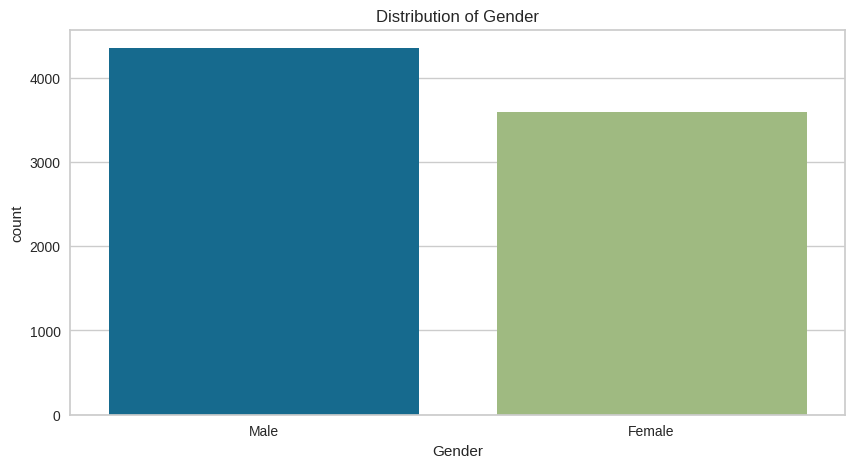

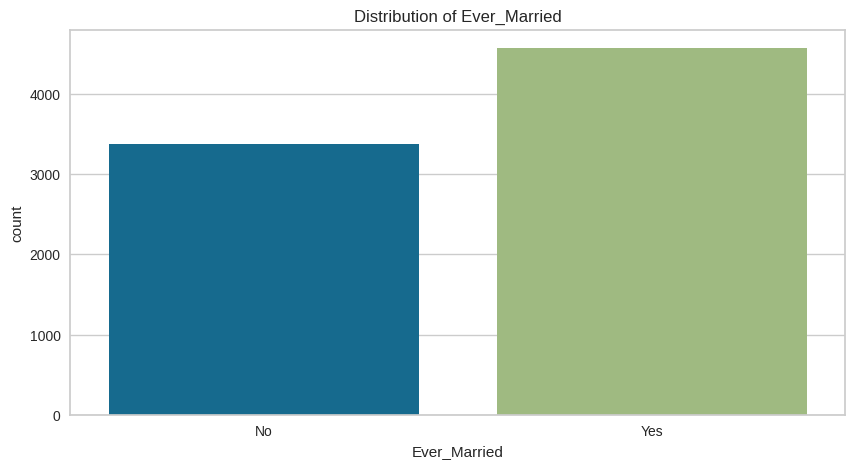

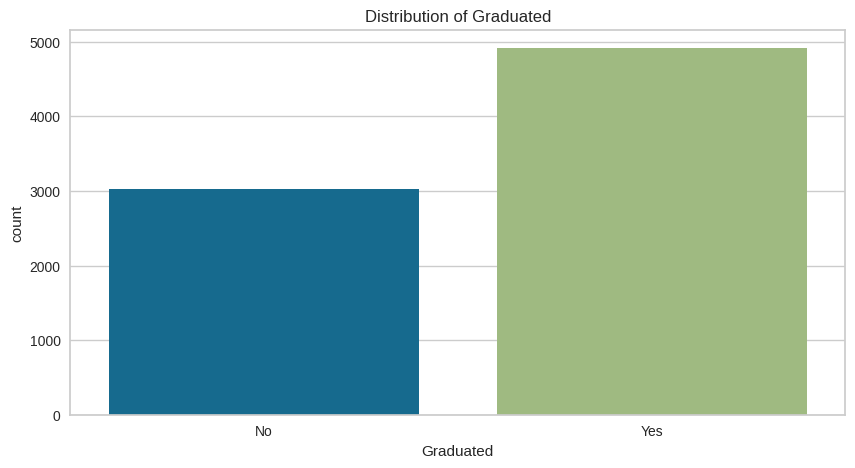

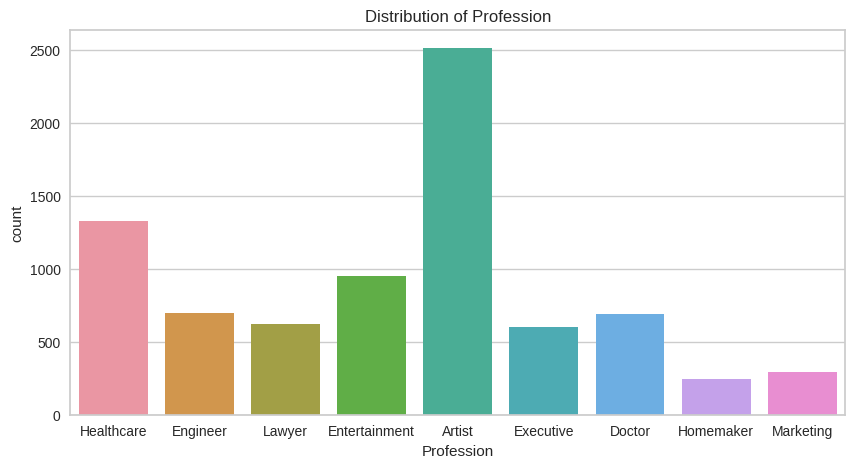

In [35]:
columns = ['Gender', 'Ever_Married', 'Graduated', 'Profession']

for col in columns:
    plt.figure(figsize=(10,5))
    sns.countplot(x=col, data=df)
    plt.title('Distribution of ' + col)
    plt.show()


**Gender**: We have a slightly more Males than females.

**Marital Status**: Somewhat higher amount of married individuals.

**Graduated**: We have about 2000 more individuals who have graduated.

**Profession**: There seems to be a large number of Artists within our population, followed by healthcare workers.

In [36]:
df.columns

Index(['Gender', 'Ever_Married', 'Age', 'Graduated', 'Profession',
       'Work_Experience', 'Spending_Score', 'Family_Size'],
      dtype='object')

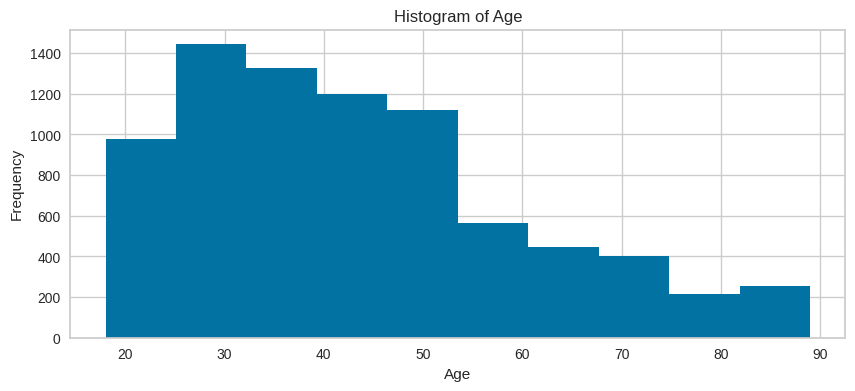

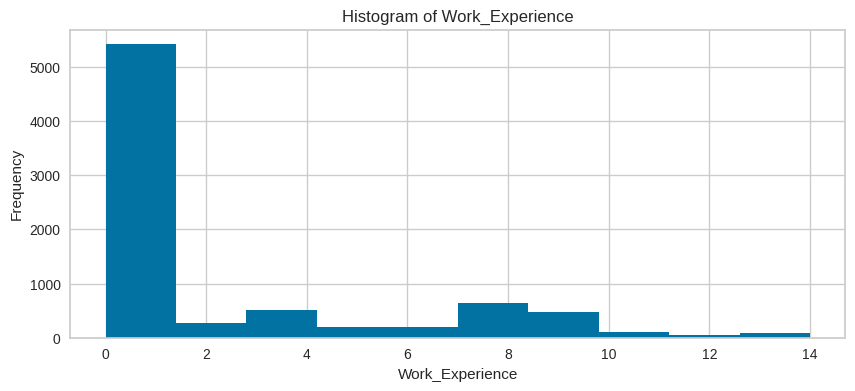

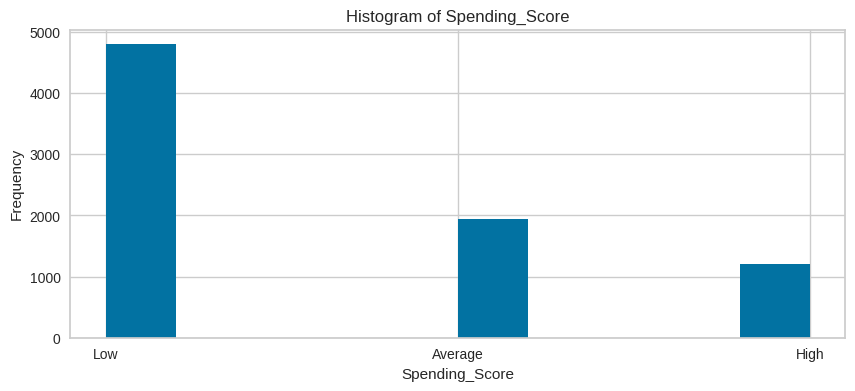

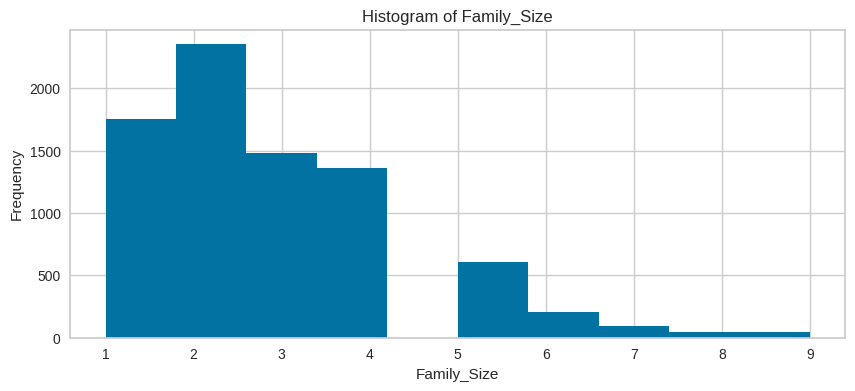

In [37]:
num_columns = ['Age', 'Work_Experience', 'Spending_Score', 'Family_Size']

for column in num_columns:
    plt.figure(figsize=(10,4))

    # For Histogram
    df[column].hist(bins=10)
    plt.title('Histogram of ' + column)
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.show()


**Age**: Age is somewhat normally distributed with a mean of about 40, however there is a slight right skew.

**Work Experience**: The majority of our population has very little to no work experience (0-1 years).

**Spending Score**: Most respondents are categorized as Low spenders, with high spenders being the smallest subgroup.

**Family Size**: Between 1 and 4 there is a normal distribution centered around 2, from 5 to 9 there is a strong right skew.

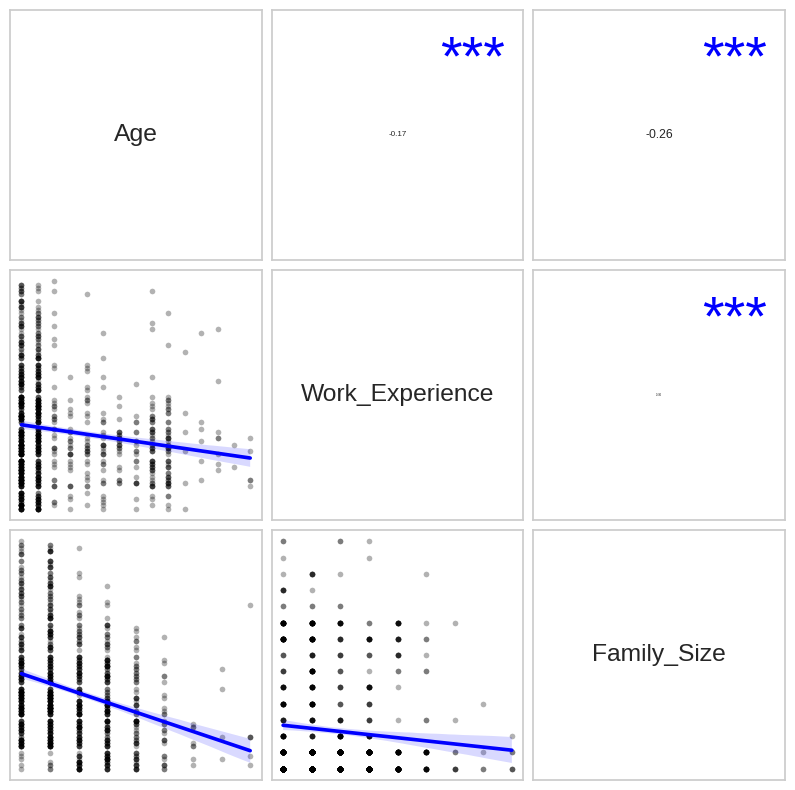

In [38]:
cr = rsm.correlation(df)
cr.plot(figsize=(10, 10))

There seems to be very little correlation between the numerical variables, thus PCA may not be necessary and we can continue with our analysis.

## Data Preprocessing

In [39]:
df1 = df.copy()
df1

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size
0,Male,No,22,No,Healthcare,1.0,Low,4.0
1,Female,Yes,38,Yes,Engineer,0.0,Average,3.0
2,Female,Yes,67,Yes,Engineer,1.0,Low,1.0
3,Male,Yes,67,Yes,Lawyer,0.0,High,2.0
4,Female,Yes,40,Yes,Entertainment,0.0,High,6.0
...,...,...,...,...,...,...,...,...
8062,Male,Yes,41,Yes,Artist,0.0,High,5.0
8064,Male,No,35,No,Executive,3.0,Low,4.0
8065,Female,No,33,Yes,Healthcare,1.0,Low,1.0
8066,Female,No,27,Yes,Healthcare,1.0,Low,4.0


In [40]:
# Convert categorical and binary columns to integers for analysis

# Categorical Columns
df1['Spending_Score'] = df1['Spending_Score'].map({'Low': 0, 'Average': 1, 'High': 2})
prof = list(df['Profession'].unique())
df1['Profession'] = df1['Profession'].apply(lambda x : prof.index(x) + 1)

# Binary Columns
df1['Gender'] = df1['Gender'].map({'Male': 1, 'Female': 0})
df1['Ever_Married'] = df1['Ever_Married'].map({'Yes': 1, 'No': 0})
df1['Graduated'] = df1['Graduated'].map({'Yes': 1, 'No': 0})


In [41]:
df1

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size
0,1,0,22,0,1,1.0,0,4.0
1,0,1,38,1,2,0.0,1,3.0
2,0,1,67,1,2,1.0,0,1.0
3,1,1,67,1,3,0.0,2,2.0
4,0,1,40,1,4,0.0,2,6.0
...,...,...,...,...,...,...,...,...
8062,1,1,41,1,5,0.0,2,5.0
8064,1,0,35,0,6,3.0,0,4.0
8065,0,0,33,1,1,1.0,0,1.0
8066,0,0,27,1,1,1.0,0,4.0


## Determining Optimal Clusters

We will use the elbow method below to determine the optimal number of clusters for our k-means analysis.

In [ ]:
sse = []
list_k = list(range(1, 10))

for k in list_k:
    km = KMeans(n_clusters=k, n_init=10)
    km.fit(df1)
    sse.append(km.inertia_)

# Plot sse against k
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance')
plt.show()

In [ ]:
print('Elbow Method to determine the number of clusters to be formed:')
Elbow_M = KElbowVisualizer(KMeans(), k=10)
Elbow_M.fit(df1)
Elbow_M.show()

From the above two plots we can see that 4 will be the optimal number of clusters. In the first graph 4 is where the SSE begins to decrease less rapidly, and this is confirmed in the second visual.

In [ ]:
kmeans = KMeans(n_clusters=4, random_state=0)

kmeans.fit(df1)

labels = kmeans.labels_


In [ ]:
df1['Cluster'] = labels
df1

In [ ]:
print(df1['Cluster'].value_counts())

In [ ]:
cluster_profiles = df1.groupby('Cluster').mean()
print(cluster_profiles)

In [ ]:
for column in cluster_profiles.columns:
    plt.figure(figsize=(10,5))
    cluster_profiles[column].plot(kind='bar')
    plt.title(f'Average {column} for Each Cluster')
    plt.ylabel(column)
    plt.show()


In [ ]:
plt.figure(figsize=(10, 6))
sns.heatmap(cluster_profiles, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Average Feature Values for Each Cluster')
plt.show()


## Cluster Analysis

Cluster 0
* Gender: 58% of respondents are male
* Ever Married:85% have been or are currently married
* Age: 54 years old
* Graduated: 78% have graduated
* Work Experience: 1.6 yrs of work experience
* Spending Score: 0.79
* Family Size: 2-3 family members per household

This group is comprised of later-adulthood individuals, with high levels of marriage and graduation. With a relatively high spending score, this group could best be targeted with middle to high end products.

Cluster 1
* Gender: 58% of respondents are male
* Ever Married: 94% have been or are currently married
* Age: 74 years old
* Graduated: 62% have graduated
* Work Experience: 1 yrs of work experience
* Spending Score: 1.05
* Family Size: 1-2 family members per household

Cluster 1 is comprised of senior respondents on average, and with the highest spending score on average and smaller family sizes, the automobile company could target these individuals with the highest end vehicles. Since the respondents of this group also have small family sizes and luxury vehicles are often smaller sports cars, this seems to be the perfect group to market that type of car towards

Cluster 2
* Gender: 54% of respondents are male
* Ever Married: 16% have been or are currently married
* Age: 26 years old
* Graduated: 36% have graduated
* Work Experience: 2.5 yrs of work experience
* Spending Score: 0.14
* Family Size: 3-4 family members per household

Cluster 2 is compromised of young adults on average, with low levels of marriage and graduation. Interestingly they have the highest average number of family members. This could be due to respondents still living at home with parents and siblings, and/or new parents with children still living at home; whereas with the two older clusters children may have already grown out of the household. These respondents also have the lowest average spending score. Taking this all into consideration, targeting this group with an economic daily driver would seemingly be the best fit.

Cluster 3
* Gender: 51% of respondents are male
* Ever Married: 62% have been or are currently married
* Age: 39 years old
* Graduated: 75% have graduated
* Work Experience: 3.3 yrs of work experience
* Spending Score: 0.54
* Family Size: 2-3 family members per household

This group is considered middle aged, and has relatively high levels of marriage and graduation. With the second lowest spending score, this group would fall somewhere in between Cluster 0 and Cluster 2 in terms of the products marketed towards them. This would be low to middle end products that are economical but also perceivably more high end than the most basic vehicles.

## Conclusion

It seems that through our analysis we were able to successfully segment our clientel into distinguishably different groups. Customer segmentation is a necessary step in truly understanding your customer base, as similar customers will have similar preferences and purchasing habits. Having the ability to identify which segment a customer best aligns with can maximize the potential revenue from that individual. This can be done through various vices, such as targeted ads, personalized messaging, etc. Additionally customer segmentation can help the business understand the wants of its consumers better. By looking at the historical purchases for a specific cluster, we can see whether their needs are being adequately met with our current product line. If not we can use this information to create new products or adapt current products to better suited to them. In summary, clustering and customer segmentation is a key step for any business that wishes to understand its customers better, and can create additional value not only for the business but for the consumer as well.